In [1]:
%matplotlib inline


# 2D inversion of Loop-Loop EM Data

In this example, we consider a single line of loop-loop EM data
at 30kHz with 3 different coil separations [0.32m, 0.71m, 1.18m].
We will use only Horizontal co-planar orientations (vertical magnetic dipole),
and look at the real and imaginary parts of the secondary magnetic field.

We use the :class:`SimPEG.maps.Surject2Dto3D` mapping to invert for a 2D model
and perform the forward modelling in 3D.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from pymatsolver import Pardiso as Solver

import discretize
from SimPEG import (
    maps,
    optimization,
    data_misfit,
    regularization,
    inverse_problem,
    inversion,
    directives,
    Report,
)
from SimPEG.electromagnetics import frequency_domain as FDEM

## Setup

Define the survey and model parameters




In [3]:
sigma_dry = 5e-2
sigma_permafrost = 6
sigma_air = 1e-15

coil_separations = [0.32, 0.71, 1.18]
freq = 30e3

print("skin_depth: {:1.2f}m".format(500 / np.sqrt(sigma_dry * freq)))

skin_depth: 12.91m


Define a dipping interface between the surface layer and the deeper layer




In [4]:
z_interface_shallow = -0.25
z_interface_deep = -1.5
x_dip = np.r_[0.0, 8.0]


def interface(x):
    interface = np.zeros_like(x)

    interface[x < x_dip[0]] = z_interface_shallow

    dipping_unit = (x >= x_dip[0]) & (x <= x_dip[1])
    x_dipping = (-(z_interface_shallow - z_interface_deep) / x_dip[1]) * (
        x[dipping_unit]
    ) + z_interface_shallow
    interface[dipping_unit] = x_dipping

    interface[x > x_dip[1]] = z_interface_deep

    return interface

## Forward Modelling Mesh

Here, we set up a 3D tensor mesh which we will perform the forward
simulations on.

<div class="alert alert-info"><h4>Note</h4><p>In practice, a smaller horizontal discretization should be used to improve
  accuracy, particularly for the shortest offset (eg. you can try 0.25m).</p></div>



the mesh has 34200 cells


<Axes3DSubplot:xlabel='x1', ylabel='x2'>

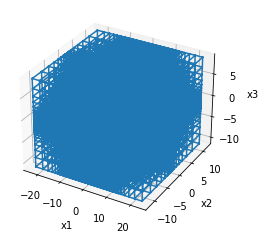

In [5]:
csx = 0.5  # cell size for the horizontal direction
csz = 0.125  # cell size for the vertical direction
pf = 1.3  # expansion factor for the padding cells

npadx = 7  # number of padding cells in the x-direction
npady = 7  # number of padding cells in the y-direction
npadz = 11  # number of padding cells in the z-direction

core_domain_x = np.r_[-11.5, 11.5]  # extent of uniform cells in the x-direction
core_domain_z = np.r_[-2.0, 0.0]  # extent of uniform cells in the z-direction

# number of cells in the core region
ncx = int(np.diff(core_domain_x) / csx)
ncz = int(np.diff(core_domain_z) / csz)

# create a 3D tensor mesh
mesh = discretize.TensorMesh(
    [
        [(csx, npadx, -pf), (csx, ncx), (csx, npadx, pf)],
        [(csx, npady, -pf), (csx, 1), (csx, npady, pf)],
        [(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)],
    ]
)
# set the origin
mesh.x0 = np.r_[
    -mesh.hx.sum() / 2.0, -mesh.hy.sum() / 2.0, -mesh.hz[: npadz + ncz].sum()
]

print("the mesh has {} cells".format(mesh.nC))
mesh.plotGrid()

## Inversion Mesh

Here, we set up a 2D tensor mesh which we will represent the inversion model
on



<AxesSubplot:xlabel='x1', ylabel='x2'>

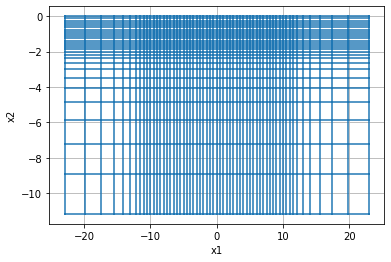

In [6]:
inversion_mesh = discretize.TensorMesh([mesh.hx, mesh.hz[mesh.vectorCCz <= 0]])
inversion_mesh.x0 = [-inversion_mesh.hx.sum() / 2.0, -inversion_mesh.hy.sum()]
inversion_mesh.plotGrid()

## Mappings

Mappings are used to take the inversion model and represent it as electrical
conductivity on the inversion mesh. We will invert for log-conductivity below
the surface, fixing the conductivity of the air cells to 1e-8 S/m



In [7]:
# create a 2D mesh that includes air cells
mesh2D = discretize.TensorMesh([mesh.hx, mesh.hz], x0=mesh.x0[[0, 2]])
active_inds = mesh2D.gridCC[:, 1] < 0  # active indices are below the surface


mapping = (
    maps.Surject2Dto3D(mesh)
    * maps.InjectActiveCells(  # populates 3D space from a 2D model
        mesh2D, active_inds, sigma_air
    )
    * maps.ExpMap(  # adds air cells
        nP=inversion_mesh.nC
    )  # takes the exponential (log(sigma) --> sigma)
)

## True Model

Create our true model which we will use to generate synthetic data for



(-2.0, 0.0)

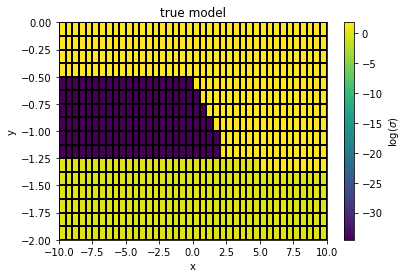

In [8]:
m_true = np.log(sigma_air) * np.ones(inversion_mesh.nC) # Création de la grille 1620
interface_depth = interface(inversion_mesh.gridCC[:, 0]) # 
m_true[inversion_mesh.gridCC[:, 1] > interface_depth*2] = np.log(sigma_permafrost)
m_true[:1000] = sigma_dry

fig, ax = plt.subplots(1, 1)
cb = plt.colorbar(inversion_mesh.plotImage(m_true, ax=ax, grid=True)[0], ax=ax)
cb.set_label("$\log(\sigma)$")
ax.set_title("true model")
ax.set_xlim([-10, 10])
ax.set_ylim([-2, 0])

## Survey

Create our true model which we will use to generate synthetic data for



In [9]:
src_locations = np.arange(-11, 11, 0.5)
src_z = 0.25  # src is 0.25m above the surface
orientation = "z"  # z-oriented dipole for horizontal co-planar loops

# reciever offset in 3D space
rx_offsets = np.vstack([np.r_[sep, 0.0, 0.0] for sep in coil_separations])

# create our source list - one source per location
srcList = []
for x in src_locations:
    src_loc = np.r_[x, 0.0, src_z]
    rx_locs = src_loc - rx_offsets

    rx_real = FDEM.Rx.PointMagneticFluxDensitySecondary(
        locations=rx_locs, orientation=orientation, component="real"
    )
    rx_imag = FDEM.Rx.PointMagneticFluxDensitySecondary(
        locations=rx_locs, orientation=orientation, component="imag"
    )

    src = FDEM.Src.MagDipole(
        receiver_list=[rx_real, rx_imag],
        loc=src_loc,
        orientation=orientation,
        freq=freq,
    )

    srcList.append(src)

# create the survey and problem objects for running the forward simulation
survey = FDEM.Survey(srcList)
prob = FDEM.Simulation3DMagneticFluxDensity(
    mesh, survey=survey, sigmaMap=mapping, Solver=Solver
)

## Set up data for inversion

Generate clean, synthetic data. Later we will invert the clean data, and
assign a standard deviation of 0.05, and a floor of 1e-11.



Done forward simulation. Elapsed time = 2432.43 s


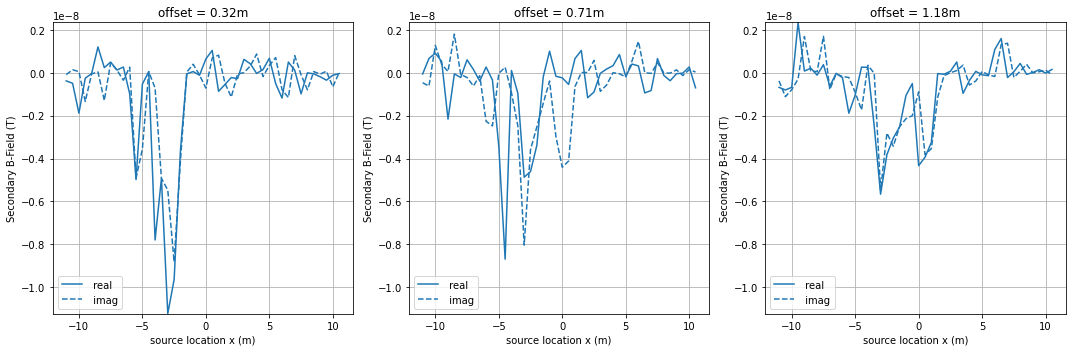

In [10]:
t = time.time()

data = prob.make_synthetic_data(
    m_true, relative_error=0.05, noise_floor=1e-11, add_noise=False
)

dclean = data.dclean
print("Done forward simulation. Elapsed time = {:1.2f} s".format(time.time() - t))


def plot_data(data, ax=None, color="C0", label=""):
    if ax is None:
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # data is [re, im, re, im, ...]
    data_real = data[0::2]
    data_imag = data[1::2]

    for i, offset in enumerate(coil_separations):
        ax[i].plot(
            src_locations,
            data_real[i :: len(coil_separations)],
            color=color,
            label="{} real".format(label),
        )
        ax[i].plot(
            src_locations,
            data_imag[i :: len(coil_separations)],
            "--",
            color=color,
            label="{} imag".format(label),
        )

        ax[i].set_title("offset = {:1.2f}m".format(offset))
        ax[i].legend()
        ax[i].grid(which="both")
        ax[i].set_ylim(np.r_[data.min(), data.max()] + 1e-11 * np.r_[-1, 1])

        ax[i].set_xlabel("source location x (m)")
        ax[i].set_ylabel("Secondary B-Field (T)")

    plt.tight_layout()
    return ax


ax = plot_data(dclean)

## Set up the inversion

We create the data misfit, simple regularization
(a Tikhonov-style regularization, :class:`SimPEG.regularization.Simple`)
The smoothness and smallness contributions can be set by including
`alpha_s, alpha_x, alpha_y` as input arguments when the regularization is
created. The default reference model in the regularization is the starting
model. To set something different, you can input an `mref` into the
regularization.

We estimate the trade-off parameter, beta, between the data
misfit and regularization by the largest eigenvalue of the data misfit and
the regularization. Here, we use a fixed beta, but could alternatively
employ a beta-cooling schedule using :class:`SimPEG.directives.BetaSchedule`



In [11]:
dmisfit = data_misfit.L2DataMisfit(simulation=prob, data=data)
reg = regularization.Simple(inversion_mesh)
opt = optimization.InexactGaussNewton(maxIterCG=10, remember="xc")
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt)

betaest = directives.BetaEstimate_ByEig(beta0_ratio=0.25)
target = directives.TargetMisfit()

directiveList = [betaest, target]
inv = inversion.BaseInversion(invProb, directiveList=directiveList)

print("The target misfit is {:1.2f}".format(target.target))

The target misfit is 132.00


## Run the inversion

We start from a half-space equal to the deep conductivity.



In [12]:
m0 = np.log(sigma_dry) * np.ones(inversion_mesh.nC)

t = time.time()
mrec = inv.run(m0)
print("\n Inversion Complete. Elapsed Time = {:1.2f} s".format(time.time() - t))

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0 -1.18e+01  3.39e+04  0.00e+00  3.39e+04    2.46e+05      0              
   1 -1.18e+01  2.04e+07  2.11e+06 -4.47e+06       nan        3              
------------------------------------------------------------------
0 :    ft     = nan <= alp*descent     = nan
1 : maxIterLS =      10    <= iterLS          =     10
------------------------- End Linesearch -------------------------
The linesearch got broken. Boo.

 Inversion Complete. Elapsed Time = 2440.90 s


## Plot the predicted and observed data




ValueError: Axis limits cannot be NaN or Inf

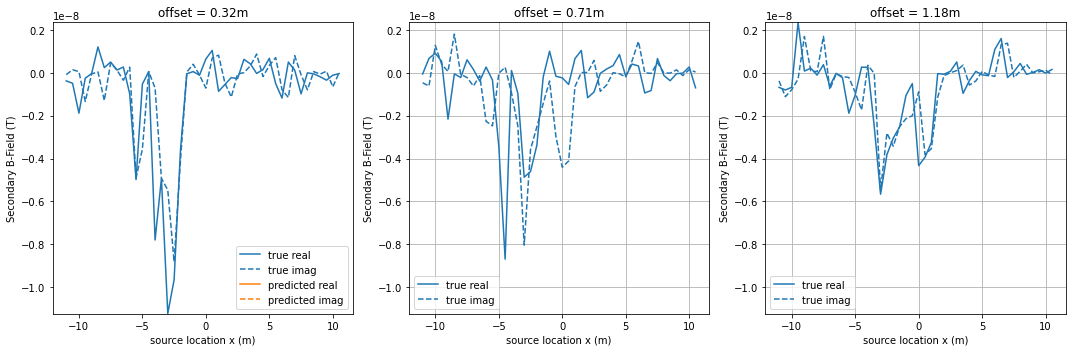

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plot_data(dclean, ax=ax, color="C0", label="true")
plot_data(invProb.dpred, ax=ax, color="C1", label="predicted")

## Plot the recovered model




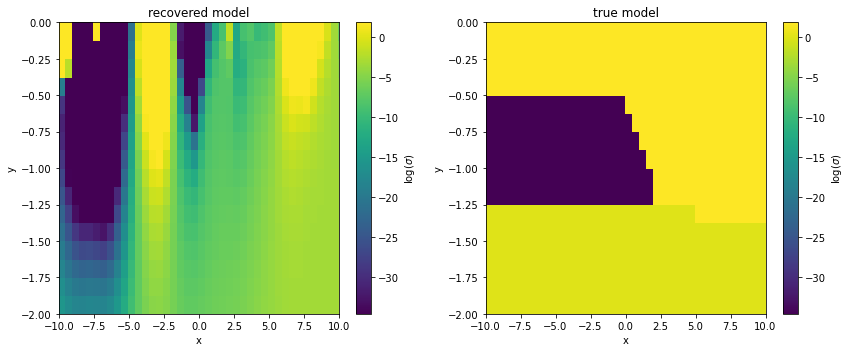

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# put both plots on the same colorbar
clim = np.r_[np.log(sigma_permafrost), np.log(sigma_air)]

# recovered model
cb = plt.colorbar(inversion_mesh.plotImage(mrec, ax=ax[0], clim=clim)[0], ax=ax[0],)
ax[0].set_title("recovered model")
cb.set_label("$\log(\sigma)$")

# true model
cb = plt.colorbar(inversion_mesh.plotImage(m_true, ax=ax[1], clim=clim)[0], ax=ax[1],)
ax[1].set_title("true model")
cb.set_label("$\log(\sigma)$")

# # uncomment to plot the true interface
# x = np.linspace(-10, 10, 50)
# [a.plot(x, interface(x), 'k') for a in ax]

[a.set_xlim([-10, 10]) for a in ax]
[a.set_ylim([-2, 0]) for a in ax]

plt.tight_layout()
plt.show()

## Print the version of SimPEG and dependencies




## Moving Forward

If you have suggestions for improving this example, please create a `pull request on the example in SimPEG <https://github.com/simpeg/simpeg/blob/master/examples/07-fdem/plot_loop_loop_2Dinversion.py>`_

You might try:
   - improving the discretization
   - changing beta
   - changing the noise model
   - playing with the regulariztion parameters
   - ...

